In [1]:
# If these are already installed in your venv, this does nothing
import sys, subprocess
for p in ["wfdb", "matplotlib"]:
    subprocess.run([sys.executable, "-m", "pip", "install", p], check=False)

import wfdb
import matplotlib.pyplot as plt


In [2]:
# This will create: data/mitdb/{100.dat, 100.hea, 100.atr}
wfdb.dl_database("mitdb", dl_dir="../data", records=["100"])
print("✅ Downloaded record 100 into data/mitdb/")


Generating record list for: 100
Generating list of all files for: 100
Finished downloading files
✅ Downloaded record 100 into data/mitdb/


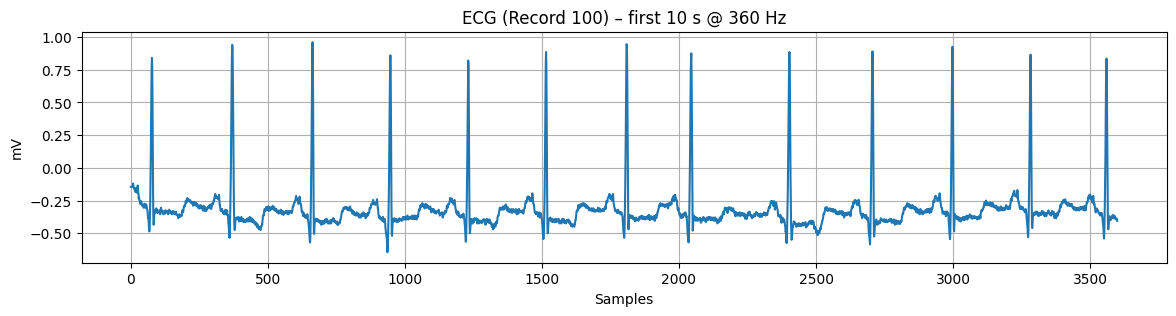

In [3]:
# Load the record
record = wfdb.rdrecord("../data/100")
fs = int(record.fs)            # sampling rate (360 Hz for MIT‑BIH)
lead0 = record.p_signal[:, 0]  # first lead (e.g., MLII)

# Plot ~10 seconds = 10 * fs samples
N = 10 * fs
plt.figure(figsize=(14, 3))
plt.plot(lead0[:N])
plt.title(f"ECG (Record 100) – first 10 s @ {fs} Hz")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()


In [4]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(signal, fs, low=0.5, high=40.0, order=4):
    nyquist = 0.5 * fs
    lowcut = low / nyquist
    highcut = high / nyquist
    b, a = butter(order, [lowcut, highcut], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, freq=60.0, Q=30):
    w0 = freq / (fs / 2)  # Normalize the frequency
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)


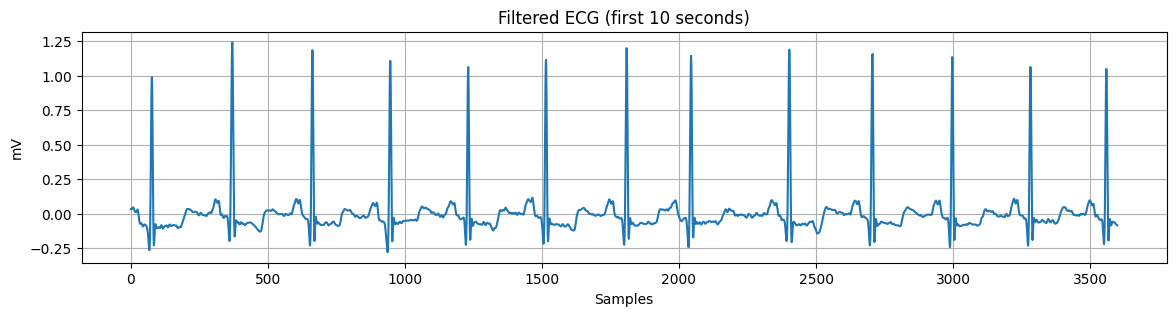

In [5]:
# Apply bandpass filter (0.5–40 Hz)
filtered = bandpass_filter(lead0, fs)

# Apply notch filter at 60 Hz (or 50 Hz depending on your country)
filtered = notch_filter(filtered, fs)

# Plot filtered signal
plt.figure(figsize=(14, 3))
plt.plot(filtered[:N])
plt.title("Filtered ECG (first 10 seconds)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()


In [6]:
import neurokit2 as nk

# Run full ECG processing pipeline
ecg_cleaned, info = nk.ecg_process(filtered, sampling_rate=fs)

# The output includes:
# - cleaned signal
# - R-peaks
# - rate
# - HRV features


c:\Users\husee\ECG-Arrhythmia-Assistant\venv\Lib\site-packages\neurokit2\ecg\ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


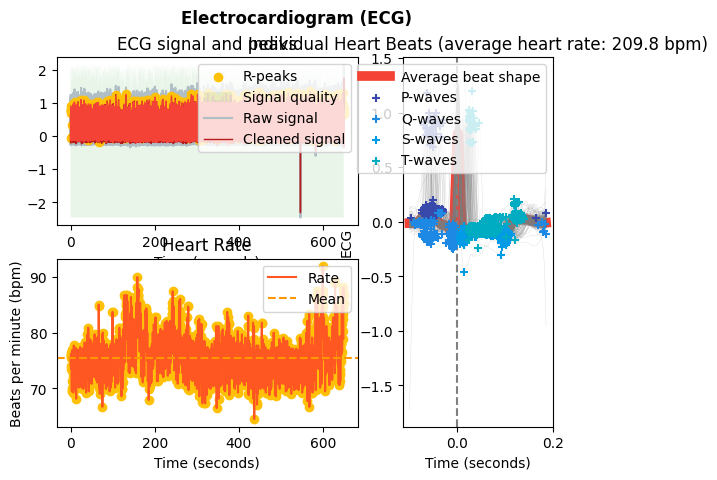

In [7]:
nk.ecg_plot(ecg_cleaned)


In [8]:
# View heart rate (BPM) over time
print("Heart rate values (BPM):")
print(ecg_cleaned["ECG_Rate"].head())

# Extract HRV features
hrv = nk.hrv_time(ecg_cleaned, sampling_rate=fs)
print("\nTime-domain HRV features:")
print(hrv.T)


Heart rate values (BPM):
0    75.507844
1    75.507844
2    75.507844
3    75.507844
4    75.507844
Name: ECG_Rate, dtype: float64

Time-domain HRV features:
                       0
HRV_MeanNN    794.619432
HRV_SDNN       37.715153
HRV_SDANN1     19.660764
HRV_SDNNI1     31.400582
HRV_SDANN2     18.278247
HRV_SDNNI2     32.455706
HRV_SDANN5     16.128590
HRV_SDNNI5     34.059644
HRV_RMSSD      32.089307
HRV_SDSD       32.096337
HRV_CVNN        0.047463
HRV_CVSD        0.040383
HRV_MedianNN  797.222222
HRV_MadNN      37.065000
HRV_MCVNN       0.046493
HRV_IQRNN      50.000000
HRV_SDRMSSD     1.175318
HRV_Prc20NN   766.666667
HRV_Prc80NN   827.777778
HRV_pNN50       8.546256
HRV_pNN20      45.594714
HRV_MinNN     652.777778
HRV_MaxNN     930.555556
HRV_HTI        10.966184
HRV_TINN        0.000000
